# Project Description

<b> Determining the cost of cars </b>

<b> Study description: </b>
Building a model that determines the cost of a car based on historical data.

<b>Research purpose:</b>
It is necessary to find the optimal algorithm with the best cost prediction quality, training time, and prediction time.

<b>Research objectives:</b>
1. <a href = '#data'>Parse</a> input data,
2. <a href = '#prepare'> Prepare</a> data,
3. Get rid of <a href='#abnormal'>abnormal</a> values,
4. Prepare <a href='#model'>models</a>,
5. <a href='#test'>Test</a> models on the RMSE metric,

<b> Initial data: </b>

Signs:
- DateCrawled - date of downloading the profile from the database
- VehicleType - type of car body
- RegistrationYear — year of car registration
- Gearbox - type of gearbox
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand - car brand
- Repaired - was the car under repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures - the number of photos of the car
- PostalCode - postal code of the owner of the profile (user)
- LastSeen - date of last user activity

Target feature:
- Price - price (EUR)


# Data Preparation

<a id = 'data'></a>
## Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [6]:
#sns.pairplot(data)

<a id = 'prepare'></a>
## Empty values

In [7]:
data.isna().sum().sort_values(ascending = False)

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Vehicle Type

In [8]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [9]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [10]:
# most frequent значения 
data.groupby('Brand')['VehicleType'].agg(pd.Series.mode)

Brand
alfa_romeo              sedan
audi                    wagon
bmw                     sedan
chevrolet               small
chrysler                  bus
citroen                 small
dacia                   wagon
daewoo                  small
daihatsu                small
fiat                    small
ford                    small
honda                   sedan
hyundai                 small
jaguar                  sedan
jeep                      suv
kia                       suv
lada                      suv
lancia                  small
land_rover                suv
mazda                   sedan
mercedes_benz           sedan
mini                    small
mitsubishi              sedan
nissan                  small
opel                    small
peugeot                 small
porsche           convertible
renault                 small
rover                   sedan
saab                    sedan
seat                    small
skoda                   wagon
smart                   small
sons

Let's fill in the missing values using the method of the most frequently occurring value according to the Brand attribute. For example, if the Alfa Romeo brand does not have the Vehicle type attribute, fill it in as a sedan.

In [11]:
data['VehicleType'] = data['VehicleType'].fillna(data.groupby('Brand')['VehicleType'].transform(lambda x: x.fillna(x.mode()[0])))

In [12]:
data['VehicleType'].isna().sum()

0

### Repaired

In [13]:
data.groupby('Price')['Repaired'].value_counts()

Price  Repaired
0      no          3479
       yes         2005
1      no           307
       yes          247
2      no             4
                   ... 
19998  no             6
19999  no           256
       yes            8
20000  no           230
       yes           10
Name: Repaired, Length: 4463, dtype: int64

In [14]:
data['Repaired'] = data['Repaired'].fillna(data.groupby('Price')['Repaired'].transform('median'))

### Fuel Type

In [15]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [16]:
data.groupby(['Model', 'Brand'])['FuelType'].value_counts()

Model   Brand       FuelType
100     audi        petrol       359
                    gasoline      15
                    lpg            8
145     alfa_romeo  petrol        43
                    gasoline       1
                                ... 
zafira  opel        petrol      1387
                    gasoline    1201
                    cng          114
                    lpg           84
                    hybrid         1
Name: FuelType, Length: 984, dtype: int64

In [17]:
data.groupby('Brand')['FuelType'].agg(pd.Series.mode)

Brand
alfa_romeo          petrol
audi                petrol
bmw                 petrol
chevrolet           petrol
chrysler            petrol
citroen             petrol
dacia               petrol
daewoo              petrol
daihatsu            petrol
fiat                petrol
ford                petrol
honda               petrol
hyundai             petrol
jaguar              petrol
jeep                petrol
kia                 petrol
lada                petrol
lancia              petrol
land_rover        gasoline
mazda               petrol
mercedes_benz       petrol
mini                petrol
mitsubishi          petrol
nissan              petrol
opel                petrol
peugeot             petrol
porsche             petrol
renault             petrol
rover               petrol
saab                petrol
seat                petrol
skoda               petrol
smart               petrol
sonstige_autos      petrol
subaru              petrol
suzuki              petrol
toyota              pe

Similarly to the type of Car body, let's fill in the most frequently occurring value in accordance with the sign of the Car Brand.

In [18]:
data['FuelType'] = data['FuelType'].fillna(data.groupby('Brand')['FuelType']\
                                           .transform(lambda x: x.fillna(x.mode()[0])))

In [19]:
data['FuelType'].isna().sum()

0

### Model

In [20]:
data.groupby('Brand')['Model'].value_counts().sort_values(ascending = False)

Brand       Model             
volkswagen  golf                  29232
bmw         3er                   19761
volkswagen  polo                  13066
opel        corsa                 12570
            astra                 10809
                                  ...  
rover       freelander                3
land_rover  range_rover_evoque        2
            serie_1                   2
rover       discovery                 2
            defender                  1
Name: Model, Length: 297, dtype: int64

Fill in the missing values in accordance with the same sign Car brand.

In [21]:
data['Model'] = data['Model'].fillna(data.groupby('Brand')['Model']\
                                           .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')))

In [22]:
data['Model'].isna().sum()

0

#### Gearbox

In [23]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [24]:
data.groupby(['Model'])['Gearbox'].value_counts()

Model    Gearbox
100      manual      336
         auto         63
145      manual       40
147      manual      520
         auto         29
                    ... 
ypsilon  auto         16
z_reihe  manual      625
         auto         76
zafira   manual     2573
         auto        308
Name: Gearbox, Length: 487, dtype: int64

In [25]:
data['Gearbox'] = data['Gearbox'].fillna(data.groupby(['Model'])['Gearbox']\
                                         .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')))


In [26]:
data['Gearbox'].isna().sum()

0

<a id = 'abnorma'></a>
## Data clearing

### Irrelevant values

Let's get rid of signs of the date the profile was downloaded, the date the profile was created, the number of pictures, the postal code and the date of the last user activity.

In [27]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [28]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Abnormal values

A function that determines the distribution of a feature in the form of a histogram and a range diagram. Takes a sign as input. At the output: 2 charts and the minimum and maximum values of the feature.

In [29]:
def plotting(feature):
    data.plot(y = feature, kind = 'hist', title = 'Распределение {}'.format(feature), grid = True, bins = 30, figsize = (15, 3))
    plt.xlabel('{}'.format(feature))
    plt.show()
    fig, ax = plt.subplots(figsize = (15,2))
    ax = data[[feature]].boxplot(vert = False, ax=ax)
    ax.set_title('Диаграмма размаха значений {}'.format(feature))
    
    #print(data[[feature]].min(), data[[feature]].max())
    display(f'Минимальное значение: {data[feature].min()}')
    display(f'Максимальное значение: {data[feature].max()}')


#### Price

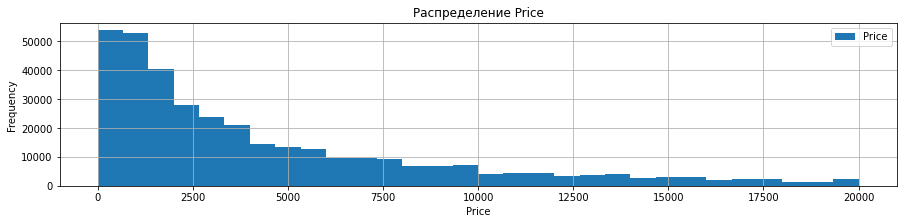

'Минимальное значение: 0'

'Максимальное значение: 20000'

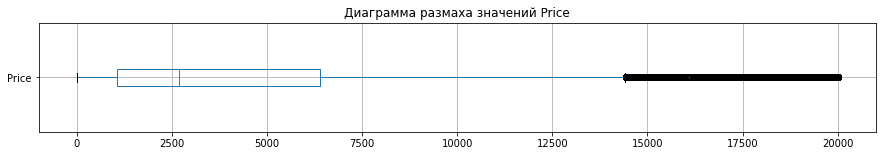

In [30]:
plotting('Price')

In [31]:
(
    data[['Price']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,Price
count,"354,369.00"
min,0.00
max,"20,000.00"


Let's get rid of the "anomalous" price value of 0 euros.

In [32]:
data[(data['Price'] == 0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,small,1990,manual,0,corsa,150000,1,petrol,opel,NaN
111,0,sedan,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
115,0,small,1999,manual,0,golf,5000,0,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,small,2000,manual,65,corsa,150000,0,petrol,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


In [33]:
data = data.loc[data['Price'] > 0]

#### Registration Year

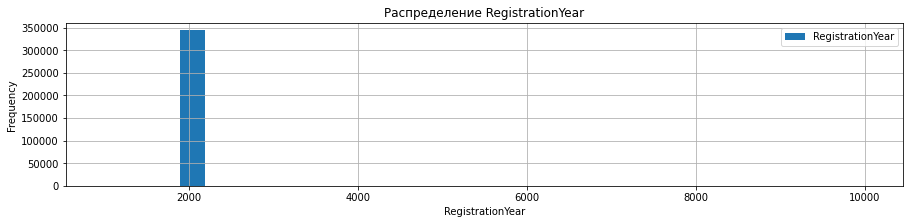

'Минимальное значение: 1000'

'Максимальное значение: 9999'

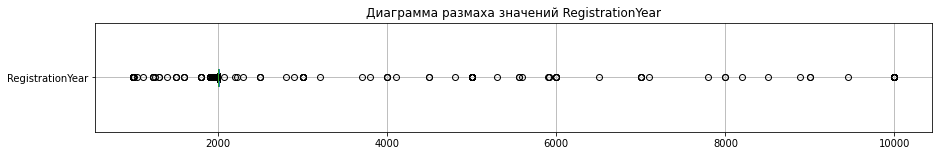

In [34]:
plotting('RegistrationYear')

In [35]:
data[(data['RegistrationYear'] > 1900) & (data['RegistrationYear'] < 1950)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
15,450,small,1910,manual,0,ka,5000,0,petrol,ford,NaN
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no
2273,1800,convertible,1925,manual,0,Unknown,5000,1,petrol,sonstige_autos,no
6977,135,small,1910,manual,0,corsa,5000,0,petrol,opel,NaN
10183,1250,wagon,1910,manual,0,other,5000,0,petrol,audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
338109,7000,coupe,1937,manual,85,other,5000,8,petrol,ford,yes
343083,1,other,1910,manual,0,golf,5000,1,other,volkswagen,NaN
346046,18900,suv,1943,manual,60,other,150000,3,petrol,volkswagen,no
353531,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN


In [36]:
data[(data['RegistrationYear'] > 2022)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
12946,49,sedan,5000,manual,0,golf,5000,12,petrol,volkswagen,NaN
15870,1700,sedan,3200,manual,0,Unknown,5000,0,petrol,sonstige_autos,NaN
17271,700,small,9999,manual,0,other,10000,0,petrol,opel,NaN
17346,6500,sedan,8888,manual,0,Unknown,10000,0,petrol,sonstige_autos,NaN
18259,300,small,2200,manual,0,twingo,5000,12,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...,...
328453,450,sedan,2500,manual,0,6_reihe,5000,0,petrol,mazda,NaN
331753,99,sedan,9999,manual,0,1er,10000,0,petrol,bmw,NaN
334967,12000,sedan,4000,manual,500,golf,5000,0,petrol,volkswagen,no
338829,50,sedan,3000,manual,3000,golf,100000,6,petrol,volkswagen,yes


In [37]:
data = data.loc[(data['RegistrationYear'] > 1900) & (data['RegistrationYear'] < 2016)]

#### Registration Month

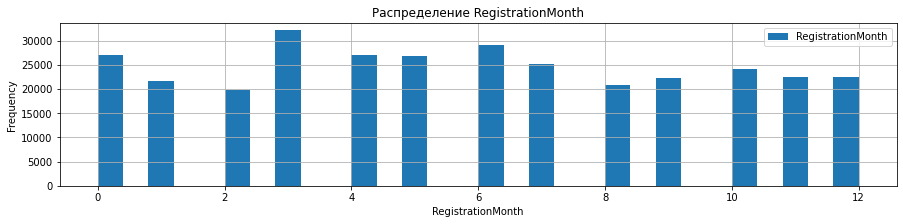

'Минимальное значение: 0'

'Максимальное значение: 12'

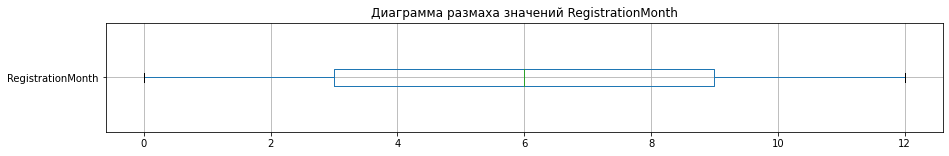

In [38]:
plotting('RegistrationMonth')

In [39]:
data['RegistrationMonth'].value_counts()

3     32074
6     29055
4     27023
0     26958
5     26889
7     25231
10    24221
11    22509
12    22483
9     22202
1     21542
8     20843
2     19767
Name: RegistrationMonth, dtype: int64

In [40]:
data = data[data['RegistrationMonth'] != 1]

#### Kilometer

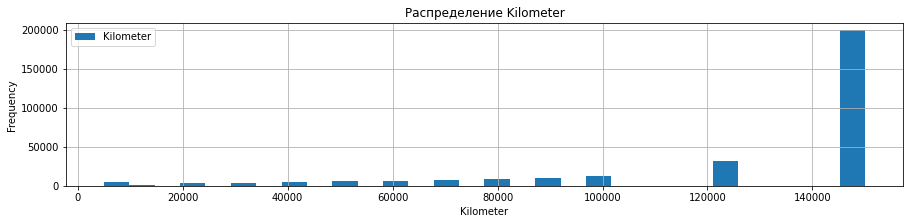

'Минимальное значение: 5000'

'Максимальное значение: 150000'

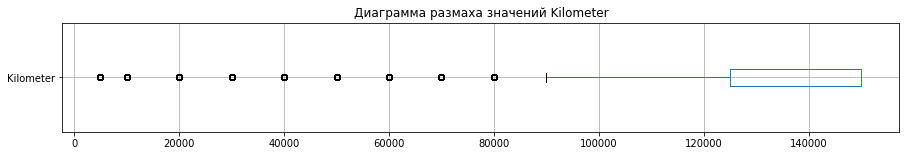

In [41]:
plotting('Kilometer')

#### Power

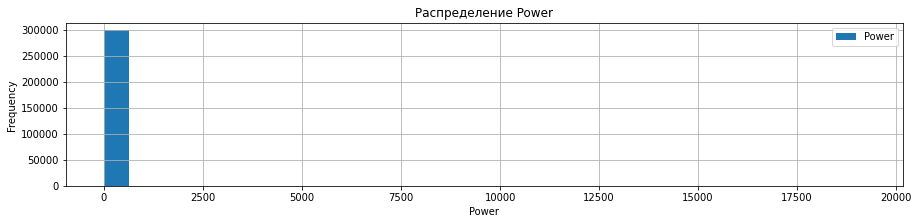

'Минимальное значение: 0'

'Максимальное значение: 19211'

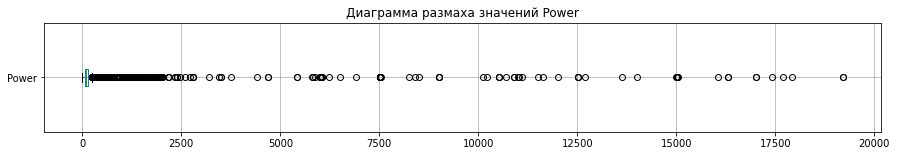

In [42]:
plotting('Power')

In [43]:
data.loc[data['Power'] < 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
15,450,small,1910,manual,0,ka,5000,0,petrol,ford,NaN
17,1750,small,2004,auto,75,twingo,150000,2,petrol,renault,no
...,...,...,...,...,...,...,...,...,...,...,...
354356,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no


Power values (in horsepower) cannot exceed 2000.

In [44]:
data = data.loc[data['Power'] < 2000]

## One-Hot Encoding & Label Encoding

We convert the categorical features 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired' into numerical ones using the dummy trap bypass coding method.

In [45]:
categorical = data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']]

In [46]:
list(categorical.columns)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

### OHE 

In [47]:
cat_col = categorical.columns
OHE = OneHotEncoder()

array_ohe = OHE.fit_transform(data[cat_col]).toarray() # Переводим в NumPy
data_ohe = pd.DataFrame(array_ohe, index=data.index, columns=OHE.get_feature_names()) # Добавляем имена колонок.
data_other = data.drop(columns=cat_col)
data_final = pd.concat([data_ohe, data_other], axis=1)

In [48]:
data_final.head()

,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_auto,x1_manual,...,x4_volkswagen,x4_volvo,x5_no,x5_yes,x5_nan,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,480,1993,0,150000,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,18300,2011,190,125000,5
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,9800,2004,163,125000,8
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1500,2001,75,150000,6
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,3600,2008,69,90000,7


### Ordinal Encoder

In [49]:
data.dropna(inplace= True)

In [50]:
ENC = OrdinalEncoder()

array_enc = ENC.fit_transform(data[cat_col])
data_enc = pd.DataFrame(array_enc, index=data.index)#, columns=ENC.get_feature_names_out())
data_other_enc = data.drop(columns=cat_col)
data_final_enc = pd.concat([data_enc, data_other_enc], axis=1)

In [51]:
ENC.categories_

[array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
        'wagon'], dtype=object),
 array(['auto', 'manual'], dtype=object),
 array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
        '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
        '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
        '9000', '911', 'Unknown', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
        'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
        'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
        'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
        'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
        'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
        'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
        'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
        'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'crom

In [52]:
data_final_enc.head()

,0,1,2,3,4,5,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
1,2.0,1.0,30.0,2.0,1.0,1.0,18300,2011,190,125000,5
3,5.0,1.0,117.0,6.0,38.0,0.0,1500,2001,75,150000,6
4,5.0,1.0,102.0,2.0,31.0,0.0,3600,2008,69,90000,7
5,4.0,1.0,11.0,6.0,2.0,1.0,650,1995,102,150000,10
6,1.0,1.0,8.0,6.0,25.0,0.0,2200,2004,109,150000,8


<a id = 'model'></a>
# Model training

Let's prepare the models, the target attribute of which is the Price, and divide the samples into training and target ones, respectively.
Also, we will scale the features of the training sample, without a test and target feature.

In [53]:
def model_preparation(df, name):
    
    features_name = df.drop(['Price'], axis=1)
    target_name = df['Price']
    
    features_train_name, features_test_name, target_train_name, target_test_name = train_test_split(features_name, target_name, test_size=0.2, random_state=1)
    
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    
    scaler = StandardScaler()
    scaler.fit(features_train_name[numeric])
               
    features_train_name[numeric] = scaler.transform(features_train_name[numeric])
    features_test_name[numeric] = scaler.transform(features_test_name[numeric])         
    
    print('Train set shape: ', features_train_name.shape, target_train_name.shape)
    print('Test set shape: ', features_test_name.shape, target_test_name.shape)
               
    
    return features_train_name, features_test_name, target_train_name, target_test_name   

<a id = 'test'></a>
# Model Analysis

In [54]:
def grid_param2(df, name, new_model, params):
    
    features_train, features_test, target_train, target_test = model_preparation(df, name)
    
    grid_model = GridSearchCV(new_model, params, scoring='neg_root_mean_squared_error')
    grid_model.fit(features_train, target_train)
    
    t_train = time.time()
    model = grid_model.best_estimator_
    model.fit(features_train, target_train)
    display(f' Model training in {round(time.time() - t_train, 2)} s')
    
    t_predict = time.time()
    preds = grid_model.predict(features_test)
    display(f' Model prediction in {round(time.time() - t_predict, 2)} s')
    
    display(f'RMSE: {mean_squared_error(target_test, preds, squared=False)}')
    display(f'Best parameters: {grid_model.best_params_}')
    display(f'Best score: {grid_model.best_score_}')

## Linear Regression

To evaluate and compare models, we need model training time (without hyperparameter fitting) and prediction time. They must be kept separately.

In [ ]:
%%time

parameters_lr = {
    'n_jobs' : range(0, 10)
}

grid_param2(data_final, 'ohe', LinearRegression(), parameters_lr)

Train set shape:  (239330, 315) (239330,)
Test set shape:  (59833, 315) (59833,)


## Decision Tree Regressor

In [331]:
%%time 

parameters_dtr = {
    'max_depth' : range(1, 5)
}

grid_param2(data_final_enc, 'enc', DecisionTreeRegressor(random_state=1), parameters_dtr)

Train set shape:  (239330, 10) (239330,)
Test set shape:  (59833, 10) (59833,)


' Model training in 0.21 s'

' Model prediction in 0.01 s'

'RMSE: 2526.340198034786'

"Best parameters: {'max_depth': 4}"

'Best score: -2524.2376235902684'

CPU times: user 3.1 s, sys: 303 ms, total: 3.41 s
Wall time: 3.41 s


## LGBM Regressor

In [334]:
parameters_lgbm = {
    'n_estimators' : range(80, 160, 20),
    'num_leaves' : range(30, 40, 2),
    'max_depth' : range(-3, 5, 20)
}

grid_param2(data_final_enc, 'enc', LGBMRegressor(random_state=1), parameters_lgbm)

Train set shape:  (239330, 10) (239330,)
Test set shape:  (59833, 10) (59833,)


' Model training in 1.32 s'

' Model prediction in 0.1 s'

'RMSE: 1666.8899278337117'

"Best parameters: {'max_depth': -3, 'n_estimators': 140, 'num_leaves': 38}"

'Best score: -1665.809890522955'

As you can see, as n_estimators and num_leaves increase, the model improves the values. The best value is max_depth = -1 (default).

It is important to note that the algorithm is ten times faster than conventional algorithms - Linear Regression and Random Forest Model.

## LGBM Regressor Тестовая Выборка

In [335]:
model = LGBMRegressor(random_state=1, n_estimators=140, num_leaves=38, max_depth=-3)
model.fit(features_train, target_train)
preds = model.predict(features_test)

display(f'RMSE: {mean_squared_error(target_test, preds, squared=False)}')

'RMSE: 1651.6326527587978'

# Conclusion

We have carried out work on forecasting prices for cars.

Having studied the data, pre-processed it and divided it into training, validation and test sets, we analyzed the operation of the Linear Regression, Decision Tree and Gradient Boosting - LGBM algorithms:

1. The Linear Regressor model has a low prediction result - RMSE: 2750 and the algorithm training period is 3.81s, the prediction period is 0.35s.
2. Model Decision Tree Regressor - RMSE: 2526, algorithm training period - 0.21s, prediction period - 0.01s.
3. Model Gradient Bossting - LGBM best prediction: RMSE: 1667 algorithm training period - 1.32s, prediction period - 0.01s.


We can <b>conclude</b> that the <b>LGBM Gradient Boosting method showed the best results</b> in predicting the price by the RMSE metric and the running time of the algorithms.